# 파일 업로드

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

In [ ]:
!unzip -q cow_csv.zip # 압축파일 이름 확인

In [ ]:
!ls

In [ ]:
!ls cow

Epoch 01 | train=0.0323  val=0.0232
Epoch 02 | train=0.0235  val=0.0218
Epoch 03 | train=0.0225  val=0.0200
Epoch 04 | train=0.0212  val=0.0209
Epoch 05 | train=0.0208  val=0.0197
Epoch 06 | train=0.0203  val=0.0202
Epoch 07 | train=0.0199  val=0.0193
Epoch 08 | train=0.0194  val=0.0202
Epoch 09 | train=0.0190  val=0.0209
Epoch 10 | train=0.0187  val=0.0195
Epoch 11 | train=0.0183  val=0.0199
Epoch 12 | train=0.0181  val=0.0194
Epoch 13 | train=0.0177  val=0.0207
Epoch 14 | train=0.0173  val=0.0203
Epoch 15 | train=0.0171  val=0.0199
Epoch 16 | train=0.0168  val=0.0196
Epoch 17 | train=0.0165  val=0.0200
Epoch 18 | train=0.0160  val=0.0210
Epoch 19 | train=0.0157  val=0.0212
Epoch 20 | train=0.0154  val=0.0210
Epoch 21 | train=0.0153  val=0.0216
Epoch 22 | train=0.0147  val=0.0212
Epoch 23 | train=0.0144  val=0.0228
Epoch 24 | train=0.0143  val=0.0211
Epoch 25 | train=0.0138  val=0.0235
Epoch 26 | train=0.0134  val=0.0232
Epoch 27 | train=0.0134  val=0.0234
Epoch 28 | train=0.0129  val

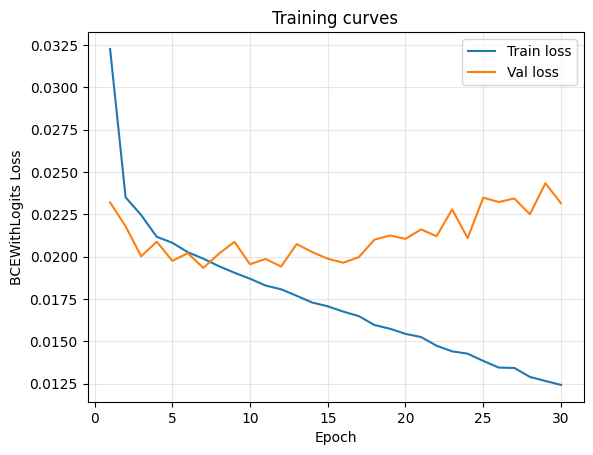

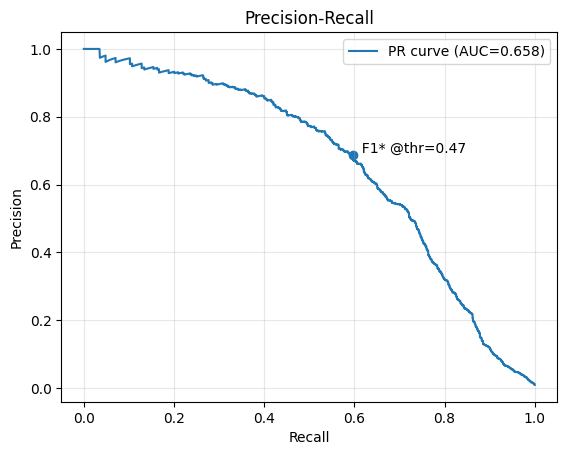

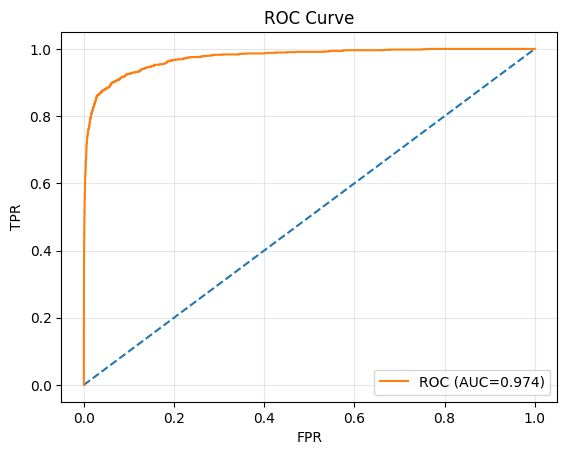

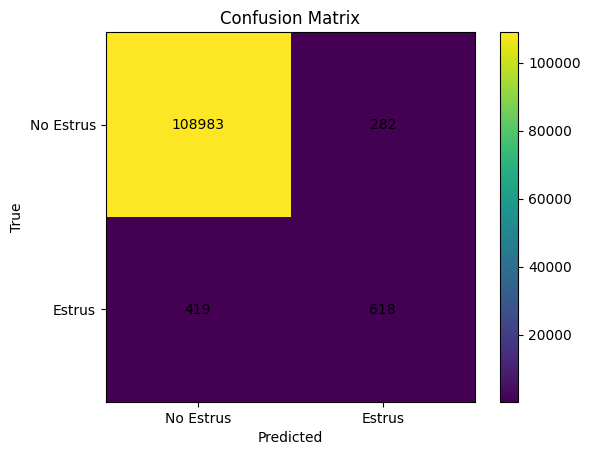

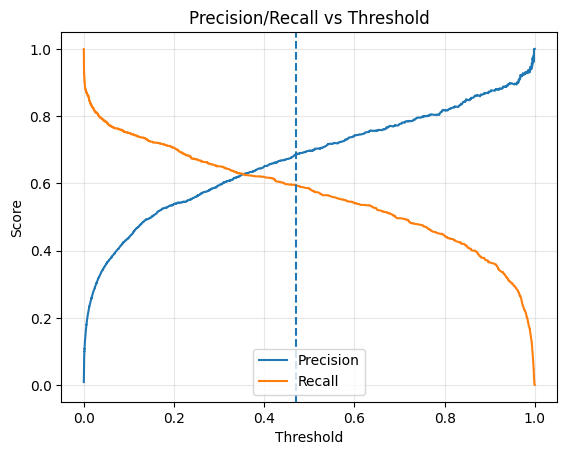

/tmp/ipython-input-3685248889.py:223: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(recalls, vert=True, labels=['Recall'])


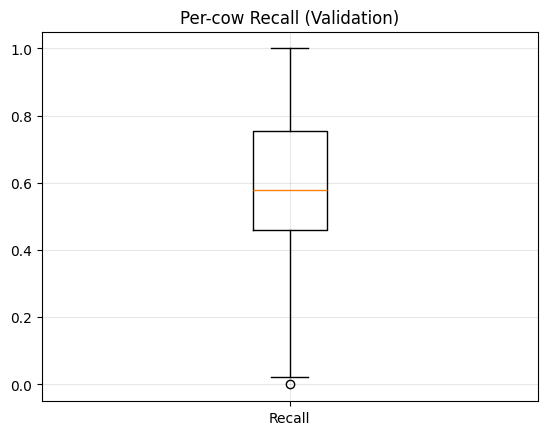

In [39]:
# -*- coding: utf-8 -*-
import pandas as pd, numpy as np, glob, torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, precision_recall_curve, auc, confusion_matrix

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
SEQ_LEN = 24
BATCH   = 128
EPOCHS  = 30
LR      = 1e-3
POS_THRESH = 25.0  # 라벨 기준 (검증에서 임계값 재튜닝)

# 1) 데이터 로드 (이미 cow_data.csv로 정제돼있다면 그걸 바로 사용)
# data = pd.read_csv('cow_data.csv')
# 또는 원시 csv 폴더가 있다면 병합
csv_list = glob.glob('./cow/*.csv')
dfs = []
for p in csv_list:
    df = pd.read_csv(p, low_memory=False)
    if '시간' in df.columns: df.rename(columns={'시간':'시간(시:분)'}, inplace=True)
    cols = ['개체 번호','날짜','시간(시:분)','활동량','전체 반추 시간(분)','발정 확률']
    df = df[cols].dropna()
    df['datetime'] = pd.to_datetime(df['날짜'] + ' ' + df['시간(시:분)'])
    df = df[['개체 번호','datetime','활동량','전체 반추 시간(분)','발정 확률']]
    dfs.append(df)
data = pd.concat(dfs, ignore_index=True)
data.sort_values(['개체 번호','datetime'], inplace=True)

# 2) 시퀀스 생성 (개체별)
FEATURES = ['활동량','전체 반추 시간(분)']
def make_sequences_by_cow(df, seq_len=24):
    Xs, ys, cows = [], [], []
    for cid, g in df.groupby('개체 번호'):
        g = g.sort_values('datetime')
        vals = g[FEATURES + ['발정 확률']].to_numpy()
        if len(vals) <= seq_len: continue
        # 개체별 스케일링: 입력(2개 feature)만 표준화. 타깃은 원스케일 유지.
        scaler = StandardScaler()
        feats = scaler.fit_transform(vals[:, :2])
        prob  = vals[:, 2]
        for i in range(len(vals) - seq_len):
            x = feats[i:i+seq_len, :]             # (seq, 2)
            y_next_prob = prob[i+seq_len]         # 다음 시점 확률
            y = 1.0 if y_next_prob >= POS_THRESH else 0.0
            Xs.append(x); ys.append(y); cows.append(cid)
    return np.array(Xs, dtype=np.float32), np.array(ys, dtype=np.float32), np.array(cows)

X, y, cows = make_sequences_by_cow(data, SEQ_LEN)

# 3) 개체 단위 Train/Val split (누수 방지)
unique_ids = np.random.permutation(np.unique(cows))
n_train = int(len(unique_ids)*0.8)
train_ids, val_ids = set(unique_ids[:n_train]), set(unique_ids[n_train:])

train_mask = np.isin(cows, list(train_ids))
val_mask   = np.isin(cows, list(val_ids))

X_train, y_train = X[train_mask], y[train_mask]
X_val,   y_val   = X[val_mask],   y[val_mask]

class CowDS(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X)        # (N, seq, 2)
        self.y = torch.from_numpy(y).unsqueeze(1)  # (N, 1)
    def __len__(self): return len(self.X)
    def __getitem__(self, i): return self.X[i], self.y[i]

train_loader = DataLoader(CowDS(X_train, y_train), batch_size=BATCH, shuffle=True, drop_last=True)
val_loader   = DataLoader(CowDS(X_val,   y_val),   batch_size=BATCH, shuffle=False)

# 4) LSTM 분류기
class LSTMClassifier(nn.Module):
    def __init__(self, input_size=2, hidden=64, layers=2, dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden, layers, batch_first=True, dropout=dropout)
        self.fc   = nn.Linear(hidden, 1)
    def forward(self, x):
        out, _ = self.lstm(x)          # (B, T, H)
        last = out[:, -1, :]           # 마지막 타임스텝
        logit = self.fc(last)          # (B, 1)
        return logit                   # 로짓 출력

model = LSTMClassifier().to(DEVICE)
criterion = nn.BCEWithLogitsLoss()     # 이진 분류
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

def run_epoch(loader, train=True):
    model.train() if train else model.eval()
    total = 0.0
    with torch.set_grad_enabled(train):
        for xb, yb in loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            if train: optimizer.zero_grad()
            logit = model(xb)
            loss = criterion(logit, yb)
            if train:
                loss.backward()
                optimizer.step()
            total += loss.item()
    return total / len(loader)

train_hist, val_hist = [], []

for ep in range(1, EPOCHS+1):
    tr = run_epoch(train_loader, True)
    va = run_epoch(val_loader, False)
    train_hist.append(tr); val_hist.append(va)
    print(f"Epoch {ep:02d} | train={tr:.4f}  val={va:.4f}")

model.eval()
import numpy as np
from sklearn.metrics import classification_report, precision_recall_curve, auc, confusion_matrix, roc_curve, roc_auc_score

all_logits, all_y = [], []
with torch.no_grad():
    for xb, yb in val_loader:
        lg = model(xb.to(DEVICE)).cpu().numpy().ravel()
        all_logits.append(lg); all_y.append(yb.numpy().ravel())
logits = np.concatenate(all_logits)
y_true = np.concatenate(all_y)
y_prob = 1/(1+np.exp(-logits))  # 시그모이드

# PR 곡선 & 최적 임계값(F1 기준)
prec, rec, ths = precision_recall_curve(y_true, y_prob)
f1s = 2*prec*rec/(prec+rec+1e-9)
best_idx = int(np.nanargmax(f1s))
best_thr = ths[best_idx] if best_idx < len(ths) else 0.5
pr_auc = auc(rec, prec)

# ROC (참고용)
fpr, tpr, roct = roc_curve(y_true, y_prob)
roc_auc = roc_auc_score(y_true, y_prob)

y_pred = (y_prob >= best_thr).astype(int)
cm = confusion_matrix(y_true, y_pred)
report = classification_report(y_true, y_pred, target_names=['No Estrus','Estrus'], digits=4)

print(f"[VAL] PR-AUC = {pr_auc:.4f} | ROC-AUC = {roc_auc:.4f}")
print(f"[VAL] Best F1 = {f1s[best_idx]:.4f} @ thr = {best_thr:.3f}")
print("Confusion matrix:\n", cm)
print(report)

# ====== (C) 시각화 (matplotlib만 사용; 각 그림은 별도 figure) ======
import matplotlib.pyplot as plt

# (1) 학습 곡선
plt.figure()
plt.plot(range(1, len(train_hist)+1), train_hist, label="Train loss")
plt.plot(range(1, len(val_hist)+1),   val_hist,   label="Val loss")
plt.xlabel("Epoch"); plt.ylabel("BCEWithLogits Loss"); plt.title("Training curves")
plt.legend(); plt.grid(True, alpha=0.3)
plt.show()

# (2) Precision-Recall 곡선 + 최고 F1 지점 표시
plt.figure()
plt.plot(rec, prec, label=f"PR curve (AUC={pr_auc:.3f})")
# 최고 F1 지점 annotation
plt.scatter(rec[best_idx], prec[best_idx])
plt.text(rec[best_idx], prec[best_idx], f"  F1* @thr={best_thr:.2f}", va='bottom')
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("Precision-Recall")
plt.grid(True, alpha=0.3); plt.legend()
plt.show()

# (3) ROC 곡선
plt.figure()
plt.plot([0,1],[0,1], linestyle="--")
plt.plot(fpr, tpr, label=f"ROC (AUC={roc_auc:.3f})")
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC Curve")
plt.grid(True, alpha=0.3); plt.legend()
plt.show()

# (4) 혼동행렬(문자열 주석 포함)
def plot_confusion_matrix(cm, class_names=('No Estrus','Estrus')):
    plt.figure()
    ax = plt.gca()
    im = ax.imshow(cm, interpolation='nearest')
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted"); plt.ylabel("True")
    ax.set_xticks([0,1]); ax.set_yticks([0,1])
    ax.set_xticklabels(class_names); ax.set_yticklabels(class_names)

    # 셀 값 주석
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, str(cm[i, j]), ha="center", va="center")
    plt.colorbar(im)
    plt.show()

plot_confusion_matrix(cm)

# (5) 임계값-정밀도/재현율 곡선 (튜닝 참고)
# precision_recall_curve의 thresholds 길이는 n-1이므로 정렬 주의
plt.figure()
x = ths if len(ths)>0 else np.array([0.5])
prec_for_th = prec[:-1] if len(prec)==len(rec) and len(ths)==len(prec)-1 else prec[1:]
rec_for_th  = rec[:-1]  if len(rec)==len(prec) and len(ths)==len(rec)-1  else rec[1:]

plt.plot(x, prec_for_th, label="Precision")
plt.plot(x, rec_for_th,  label="Recall")
plt.axvline(best_thr, linestyle="--")
plt.xlabel("Threshold"); plt.ylabel("Score"); plt.title("Precision/Recall vs Threshold")
plt.grid(True, alpha=0.3); plt.legend()
plt.show()


In [ ]:
여기부터

In [2]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving cow_csv.zip to cow_csv.zip
User uploaded file "cow_csv.zip" with length 8685509 bytes


업로드한 파일의 압축을 해제합니다.

In [3]:
!unzip -q cow_csv.zip # 압축파일 이름 확인

In [4]:
!ls

cow  cow_csv.zip  sample_data


In [5]:
!ls cow

'월별 lely 활동량 (24.01).csv'	'월별 lely 활동량 (24.07).csv'
'월별 lely 활동량 (24.02).csv'	'월별 lely 활동량 (24.08).csv'
'월별 lely 활동량 (24.03).csv'	'월별 lely 활동량 (24.09).csv'
'월별 lely 활동량 (24.04).csv'	'월별 lely 활동량 (24.10).csv'
'월별 lely 활동량 (24.05).csv'	'월별 lely 활동량 (24.11).csv'
'월별 lely 활동량 (24.06).csv'	'월별 lely 활동량 (24.12)~12.22.csv'


# 데이터셋

## 1. 데이터 전처리



In [6]:
import glob
import pandas as pd
import numpy as np

In [7]:
csv_list = glob.glob('./cow/*.csv')
csv_list.sort()

tmp = [] # 데이터를 임시저장할  빈 리스트
for csvfile in csv_list:
    try:
        print(csvfile)
        df = pd.read_csv(csvfile, low_memory=False)

        if '시간' in df.columns:
            df.rename(columns={'시간': '시간(시:분)'}, inplace=True)

        selected_cols = ['개체 번호', '날짜', '시간(시:분)', '활동량', '전체 반추 시간(분)', '발정 확률']
        df = df[selected_cols]

        df = df.dropna(axis=0, inplace=False)

        tmp.append(df)
    except Exception as e:
        print(f"{csvfile} 처리 중 오류 발생:", e)

data = pd.concat(tmp, ignore_index=True)

./cow/월별 lely 활동량 (24.01).csv
./cow/월별 lely 활동량 (24.02).csv
./cow/월별 lely 활동량 (24.03).csv
./cow/월별 lely 활동량 (24.04).csv
./cow/월별 lely 활동량 (24.05).csv
./cow/월별 lely 활동량 (24.06).csv
./cow/월별 lely 활동량 (24.07).csv
./cow/월별 lely 활동량 (24.08).csv
./cow/월별 lely 활동량 (24.09).csv
./cow/월별 lely 활동량 (24.10).csv
./cow/월별 lely 활동량 (24.11).csv
./cow/월별 lely 활동량 (24.12)~12.22.csv


In [8]:
# 날짜와 시간 합쳐서 datetime
data['datetime'] = pd.to_datetime(data['날짜'] + ' ' + data['시간(시:분)'])
# 필요한 컬럼만 추출
data = data[['개체 번호', 'datetime', '활동량', '전체 반추 시간(분)', '발정 확률']]
data.sort_values(['개체 번호', 'datetime'], inplace=True)
data.head()

,개체 번호,datetime,활동량,전체 반추 시간(분),발정 확률
87,1,2024-01-01 00:00:00,53.0,465.0,-2.0
225,1,2024-01-01 02:00:00,37.0,483.0,-2.0
363,1,2024-01-01 04:00:00,34.0,469.0,-3.0
501,1,2024-01-01 06:00:00,45.0,486.0,-4.0
639,1,2024-01-01 08:00:00,47.0,468.0,-7.0


In [9]:
print(data.shape) # (504678, 5)
print("개체 수:", data['개체 번호'].nunique())
print("기간:", data['datetime'].min(), "→", data['datetime'].max())
print("예시 1두 샘플 간격:", data.sort_values('datetime').groupby('개체 번호')['datetime'].diff().median())

(504678, 5)
개체 수: 185
기간: 2024-01-01 00:00:00 → 2024-12-22 22:00:00
예시 1두 샘플 간격: 0 days 02:00:00


In [10]:
data['개체 번호'].unique()

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  50,  51,  52,  53,
        54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,
        67,  68,  69,  70,  71,  72,  73,  75,  76,  77,  78,  79,  80,
        81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,
        94,  95,  96,  97,  98,  99, 101, 102, 104, 105, 106, 107, 108,
       110, 111, 112, 113, 114, 116, 117, 118, 121, 122, 124, 125, 128,
       129, 131, 132, 133, 136, 137, 138, 139, 140, 143, 144, 145, 146,
       149, 150, 151, 153, 155, 156, 157, 158, 159, 161, 162, 163, 164,
       166, 167, 170, 199, 201, 203, 204, 205, 208, 211, 214, 215, 216,
       218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230,
       231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 615, 65

정제한 데이터를 저장하고 싶다면,

In [24]:
data.to_csv('cow_data.csv', encoding='utf-8-sig', index=False)

In [25]:
files.download('cow_data.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

===============================================================


***TIP:***

세션 재시작 시 위 과정을 반복하지 말고 저장한 csv 파일만 간편하게 불러오세요!

In [ ]:
files.upload()

In [ ]:
import pandas as pd
import numpy as np

data = pd.read_csv('dairy_data.csv', low_memory=False)

===============================================================

## 2. 시퀀스 정의

In [11]:
# 시퀀스 파라미터 (point 전용)
SEQ_LEN        = 12        # 입력으로 볼 과거 스텝 수 (예: 12→지난 24시간)
HORIZON_STEPS  = 1         # 정확히 몇 스텝 뒤를 예측할지
POS_THRESH     = 25.0      # 발정 확률 임계값(>=25 → 1)
FEATURES       = ['활동량','전체 반추 시간(분)']

print("SEQ_LEN:", SEQ_LEN, "| HORIZON_STEPS:", HORIZON_STEPS, "| POS_THRESH:", POS_THRESH)


SEQ_LEN: 12 | HORIZON_STEPS: 1 | POS_THRESH: 25.0


In [17]:
# 스텝 간격(시간) 추정: 개체별 시계열 간격의 중앙값들을 모아 전체 중앙값
hours_per_step = (data.sort_values(['개체 번호','datetime'])
                    .groupby('개체 번호')['datetime'].diff()
                    .dropna()
                    .dt.total_seconds().median()) / 3600
print(f"추정 간격 ≈ {hours_per_step:.2f} 시간/스텝")

# 자주 나오는 간격(분)도 같이 확인(이상치/결측 체크)
gap_counts = (data.sort_values(['개체 번호','datetime'])
                .groupby('개체 번호')['datetime'].diff()
                .dropna()
                .dt.total_seconds().div(60).round().astype(int)

                .value_counts().sort_index())
print("상위 간격(분) 빈도:\n", gap_counts.head(5))
print(gap_counts[(gap_counts.index >= 240) & (gap_counts.index <= 360)].sum())

추정 간격 ≈ 2.00 시간/스텝
상위 간격(분) 빈도:
 datetime
120    504237
240         4
360        11
480        10
600        21
Name: count, dtype: int64
15


2시간 간격이 아닌 개체가 존재한다!!
긴 공백은 6804시간...?

In [22]:
import numpy as np
import pandas as pd

FEATURES = ['활동량','전체 반추 시간(분)']
TARGET   = '발정 확률'

try:
    STEP_MIN = int(round(hours_per_step * 60))  # 2h 스텝이면 120
except NameError:
    STEP_MIN = 120

SHORT_GAP_MAX = 360  # ≤6h만 보간

# 스텝 길이(분) 확보
try:
    STEP_MIN = int(round(hours_per_step * 60))
except NameError:
    STEP_MIN = 120  # 2시간

SHORT_GAP_MAX = 360   # ≤6h 보간 허용
LONG_GAP_CUT  = 360   # >6h면 세그먼트 분리

df = data.sort_values(['개체 번호','datetime']).copy()

df['gap_min'] = (
    df.groupby('개체 번호', sort=False)['datetime']
      .diff().dt.total_seconds().div(60)
)

# 2) 세그먼트 ID 생성 (index 보존 방식) ─ apply 대신 transform / boolean cumsum
# 방법 A: transform + cumsum
df['segment_id'] = (
    df.groupby('개체 번호', sort=False)['gap_min']
      .transform(lambda s: s.fillna(0).gt(LONG_GAP_CUT).cumsum())
      .astype('int64')
)

print("세그먼트 수(개체*세그먼트 조합):",
      df.groupby(['개체 번호','segment_id']).size().shape[0])
df[['개체 번호','datetime','gap_min','segment_id']].head(8)


세그먼트 수(개체*세그먼트 조합): 426


,개체 번호,datetime,gap_min,segment_id
87,1,2024-01-01 00:00:00,NaN,0
225,1,2024-01-01 02:00:00,120.0,0
363,1,2024-01-01 04:00:00,120.0,0
501,1,2024-01-01 06:00:00,120.0,0
639,1,2024-01-01 08:00:00,120.0,0
777,1,2024-01-01 10:00:00,120.0,0
915,1,2024-01-01 12:00:00,120.0,0
1053,1,2024-01-01 14:00:00,120.0,0


In [27]:
def _fill_short_gaps(seg: pd.DataFrame, cid, sid) -> pd.DataFrame:
    seg = seg.set_index('datetime').sort_index()

    # 2h 그리드
    full_idx = pd.date_range(seg.index.min(), seg.index.max(), freq=f'{STEP_MIN}min')
    seg = seg.reindex(full_idx)

    # 입력 특성만 선형보간 (≤6h만 보간되도록 limit=3step)
    limit_steps = int(SHORT_GAP_MAX // STEP_MIN)  # 360/120=3
    for c in FEATURES:
        seg[c] = pd.to_numeric(seg[c], errors='coerce').interpolate(
            method='linear', limit=limit_steps, limit_direction='both'
        )

    # 타깃은 보간 금지
    seg[TARGET] = pd.to_numeric(seg[TARGET], errors='coerce')

    # 그룹 키 명시적으로 부여 (향후 pandas 변경에도 안전)
    seg['개체 번호'] = cid
    seg['segment_id'] = sid

    return seg.reset_index().rename(columns={'index':'datetime'})

    parts = []
for (cid, sid), g in df.groupby(['개체 번호','segment_id'], sort=False):
    parts.append(_fill_short_gaps(g, cid, sid))

data_seg = (pd.concat(parts, ignore_index=True)
              .sort_values(['개체 번호','datetime'])
              .reset_index(drop=True))

# (선택) 필요한 열만 유지
cols_keep = ['개체 번호','datetime'] + FEATURES + [TARGET,'segment_id']
data_seg = data_seg[cols_keep]

print("보간 후 크기:", data_seg.shape)


보간 후 크기: (504704, 6)


In [31]:
from sklearn.preprocessing import StandardScaler

def make_sequences_point_segmented(df, seq_len, horizon_steps, pos_thresh):
    X, y, cows, ends = [], [], [], []
    skipped_no_label = 0

    for (cid, sid), g in df.groupby(['개체 번호','segment_id']):
        g = g.sort_values('datetime')
        if len(g) <= seq_len + horizon_steps - 1:
            continue

        feats = g[FEATURES].to_numpy(np.float32)              # 입력(보간됨)
        prob  = g[TARGET].to_numpy(np.float32)                # 타깃(실측만 남음; NaN 가능)
        tms   = g['datetime'].to_numpy()

        # 세그먼트 단위 표준화(입력만)
        feats = StandardScaler().fit_transform(feats).astype(np.float32)

        last_start = len(g) - seq_len - horizon_steps + 1
        for i in range(last_start):
            tgt = i + seq_len + horizon_steps - 1
            if np.isnan(prob[tgt]):              # 라벨 시점 실측 없으면 스킵
                skipped_no_label += 1
                continue

            X.append(feats[i:i+seq_len, :])
            y.append(1.0 if prob[tgt] >= pos_thresh else 0.0)
            cows.append(cid)
            ends.append(tms[i+seq_len-1])

    return (np.asarray(X, np.float32),
            np.asarray(y, np.float32),
            np.asarray(cows),
            np.asarray(ends),
            skipped_no_label)

X, y, cows, seq_end_times, skipped = make_sequences_point_segmented(
    data_seg, SEQ_LEN, HORIZON_STEPS, POS_THRESH
)

print(f"X: {X.shape} | y: {y.shape}")
print(f"스킵(라벨 실측 없음): {skipped:,}개")



X: (500324, 12, 2) | y: (500324,)
스킵(라벨 실측 없음): 17개


## 3. 데이터 분류

일반화 성능을 보기 위해 train과 val을 개체 별로 나눔

In [34]:
import numpy as np

def split_by_cow(cows, train_ratio=0.8, seed=42):
    rng = np.random.default_rng(seed)
    uniq = np.unique(cows)
    rng.shuffle(uniq)
    n_tr = int(len(uniq) * train_ratio)
    tr_ids = set(uniq[:n_tr])
    tr = np.isin(cows, list(tr_ids))
    va = ~tr
    return tr, va

train_mask, val_mask = split_by_cow(cows, train_ratio=0.8, seed=42)

X_train, y_train = X[train_mask], y[train_mask]
X_val,   y_val   = X[val_mask],   y[val_mask]

print("Train:", X_train.shape, " Val:", X_val.shape)
print("양성비율(Train, Val):", float(y_train.mean()).__round__(4), float(y_val.mean()).__round__(4))

Train: (392550, 12, 2)  Val: (107774, 12, 2)
양성비율(Train, Val): 0.0119 0.0114


In [35]:
import torch
from torch.utils.data import Dataset, DataLoader

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

class SeqDS(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X)                    # (N, T, F)
        self.y = torch.from_numpy(y).float().unsqueeze(1)  # (N, 1)
    def __len__(self): return len(self.X)
    def __getitem__(self, i): return self.X[i], self.y[i]

train_loader = DataLoader(SeqDS(X_train, y_train), batch_size=32, shuffle=True,  drop_last=True)
val_loader   = DataLoader(SeqDS(X_val,   y_val),   batch_size=32, shuffle=False)
print(DEVICE)


cpu


In [36]:
import torch.nn as nn

class LSTMClassifier(nn.Module):
    def __init__(self, input_size=2, hidden=64, layers=2, dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden, num_layers=layers,
                            batch_first=True, dropout=dropout)
        self.fc   = nn.Linear(hidden, 1)
    def forward(self, x):
        out, _ = self.lstm(x)      # (B, T, H)
        last = out[:, -1, :]       # 마지막 타임스텝
        return self.fc(last)       # 로짓(시그모이드 이전)

model = LSTMClassifier(input_size=len(FEATURES)).to(DEVICE)

# 불균형 대응: pos_weight = (음성 수 / 양성 수)
pos = float(y_train.sum())
neg = float(len(y_train) - pos)
pos_weight = torch.tensor(neg / max(1.0, pos), device=DEVICE)

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


In [37]:
import torch.nn as nn

class LSTMClassifier(nn.Module):
    def __init__(self, input_size=2, hidden=64, layers=2, dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden, num_layers=layers,
                            batch_first=True, dropout=dropout)
        self.fc   = nn.Linear(hidden, 1)
    def forward(self, x):
        out, _ = self.lstm(x)      # (B, T, H)
        last = out[:, -1, :]       # 마지막 타임스텝
        return self.fc(last)       # 로짓(시그모이드 이전)

model = LSTMClassifier(input_size=len(FEATURES)).to(DEVICE)

# 불균형 대응: pos_weight = (음성 수 / 양성 수)
pos = float(y_train.sum())
neg = float(len(y_train) - pos)
pos_weight = torch.tensor(neg / max(1.0, pos), device=DEVICE)

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
torch.manual_seed(0)

def run_epoch(loader, train=True):
    model.train() if train else model.eval()
    tot = 0.0
    with torch.set_grad_enabled(train):
        for xb, yb in loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            logit = model(xb)
            loss = criterion(logit, yb)
            if train:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            tot += loss.item()
    return tot / len(loader)

EPOCHS = 20
tr_hist, va_hist = [], []
for ep in range(1, EPOCHS+1):
    tr = run_epoch(train_loader, True)
    va = run_epoch(val_loader,   False)
    tr_hist.append(tr); va_hist.append(va)
    print(f"Epoch {ep:02d} | train={tr:.4f}  val={va:.4f}")

plt.figure()
plt.plot(tr_hist, label='train'); plt.plot(va_hist, label='val')
plt.title('Loss'); plt.legend(); plt.grid(True, alpha=0.3); plt.show()


Epoch 01 | train=0.5889  val=0.4455
Epoch 02 | train=0.5075  val=0.4274
Epoch 03 | train=0.4763  val=0.4110
Epoch 04 | train=0.4543  val=0.4513
Epoch 05 | train=0.4368  val=0.3965


In [ ]:
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, auc, classification_report, confusion_matrix

# 검증 예측 확률
model.eval()
all_logits, all_y = [], []
with torch.no_grad():
    for xb, yb in val_loader:
        lg = model(xb.to(DEVICE)).cpu().numpy().ravel()
        all_logits.append(lg); all_y.append(yb.numpy().ravel())
logits = np.concatenate(all_logits)
y_true = np.concatenate(all_y)
y_prob = 1/(1+np.exp(-logits))

# PR/ROC, 임계값 튜닝(F1)
prec, rec, ths = precision_recall_curve(y_true, y_prob)
f1s = 2*prec*rec/(prec+rec+1e-9)
best_idx = int(np.nanargmax(f1s))
best_thr = ths[best_idx] if best_idx < len(ths) else 0.5
pr_auc = auc(rec, prec)
roc_auc = roc_auc_score(y_true, y_prob)
y_pred = (y_prob >= best_thr).astype(int)
cm = confusion_matrix(y_true, y_pred)

print(f"[VAL] PR-AUC={pr_auc:.4f}  ROC-AUC={roc_auc:.4f}  BestF1={f1s[best_idx]:.4f} @thr={best_thr:.3f}")
print(classification_report(y_true, y_pred, target_names=['No Estrus','Estrus'], digits=4))
print("Confusion matrix:\n", cm)

# 시각화
plt.figure(); plt.plot(rec, prec, label=f"PR (AUC={pr_auc:.3f})")
plt.scatter(rec[best_idx], prec[best_idx]); plt.xlabel('Recall'); plt.ylabel('Precision')
plt.grid(True, alpha=0.3); plt.legend(); plt.show()

fpr, tpr, _ = roc_curve(y_true, y_prob)
plt.figure(); plt.plot([0,1],[0,1],'--'); plt.plot(fpr, tpr, label=f"ROC (AUC={roc_auc:.3f})")
plt.xlabel('FPR'); plt.ylabel('TPR'); plt.grid(True, alpha=0.3); plt.legend(); plt.show()
